## Data Tokenization via LiPCoT

The paths utilized are defiend in the `path_module.py`

### 1. Import libraries

In [1]:
from modules.lipcot_module import *
from modules.path_module import *
import numpy as np
import os
from modules.processing_module import EEGdata
import joblib

### 2. Load the processed training data

In [2]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))

### 3. Configure LiPCoT and train tokenizer model

- `order` LPC Order
- `w_factor` warp factor
- `vocab_length` Length of vocabulary 
- `model_max_length` Maximum tokens in a tokenized data segment
- `unk_token` Unknown token string for BertTokenizer
- `tokenizer_path` path to save modified BertTokenizer
- `method` LiPCoT feature creation method
    - `=1` Dominant spectral components
    - `=2` LPC coefficients
    - `=3` Cepstrum coefficients

In [3]:
lk_settings={
    'order': 16,
    'w_factor': 0.2,
    'vocab_length': 64,
    'model_max_length': 128,
    'unk_token': '[UNK]',
    'tokenizer_path': tokenizer_path,
    'method': 3
}
lk_model=lipkot_train(train_data,lk_settings)

Saving vocabulary to e:\Research\LiPCoT\Code and Data\LiPCoT\models/modifiedBertTokenizer\vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to e:\Research\LiPCoT\Code and Data\LiPCoT\models/modifiedBertTokenizer\vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to e:\Research\LiPCoT\Code and Data\LiPCoT\models/modifiedBertTokenizer\vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to e:\Research\LiPCoT\Code and Data\LiPCoT\models/modifiedBertTokenizer\vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to e:\Research\LiPCoT\Code and Data\LiPCoT\models/modifiedBertTokenizer\vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to e:\Research\LiPCoT\

initial vocab size: 30522

Vocabulary reduction: Done
 Original vocabulary size: 30522
 New vocabulary size: 69

Tokenizer files created

Vocabulary was reduced. Requires json editing
Tokenizer loaded
 Starting to edit the json files...
 Target Special token mapping:
  Special Token: [PAD], Token ID: 0
  Special Token: [UNK], Token ID: 1
  Special Token: [CLS], Token ID: 2
  Special Token: [SEP], Token ID: 3
  Special Token: [MASK], Token ID: 4

 1. Editing added_tokens.json
 2. Editing tokenizer_config.json
 3. Model max length updated: 128
 Editing done. 
Tokenization model creation completed.

Tokenization model Validation: Passed

Tokenizer loaded with vocabulary size: 69
new vocab size: 69 words


### 4. Save tokenizer model

In [4]:
joblib.dump(lk_model, os.path.join(lipcot_model_savepath,"lipcot_model.joblib"))

['e:\\Research\\LiPCoT\\Code and Data\\LiPCoT\\models/lipcot_model\\lipcot_model.joblib']

### 5. Tokenize the signals in datasets

In [5]:
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

train_data_tokenized=encode_dataset(train_data,lk_model)
val_data_tokenized=encode_dataset(val_data,lk_model)
test_data_tokenized=encode_dataset(test_data,lk_model)

### 6. Save the tokenized datasets

In [6]:
joblib.dump(train_data_tokenized, os.path.join(tokenized_data_savepath,"train_data.joblib"))
joblib.dump(val_data_tokenized, os.path.join(tokenized_data_savepath,"val_data.joblib"))
joblib.dump(test_data_tokenized, os.path.join(tokenized_data_savepath,"test_data.joblib"))

['e:\\Research\\LiPCoT\\Code and Data\\LiPCoT\\data/tokenized\\test_data.joblib']

## Inspect LiPCoT Model

#### Obtain LPC models defined by token clusters

In [7]:
cluster_arcoeff=cluster_to_arcoef(lk_model)

#### Plot cluster PSDs

C:\Users\fahim\AppData\Local\Temp\ipykernel_10488\81829466.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('afmhot')


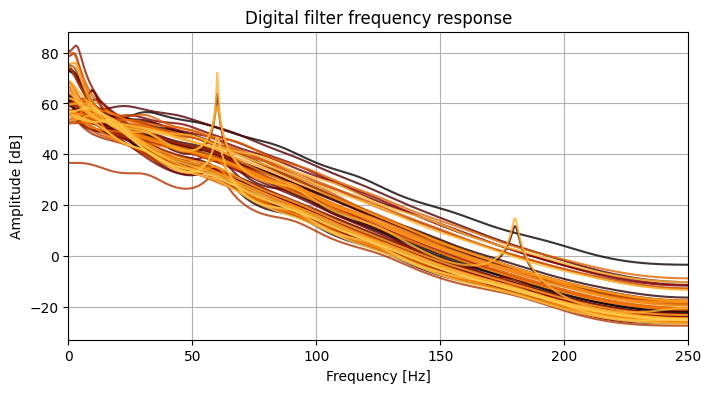

In [8]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from turbolpc.utils import freqz, arcoeff_warp # type: ignore
from turbolpc.synthesis import gen_ts  # type: ignore

cmap = get_cmap('afmhot')
plt.figure(figsize=(8,4))
Fs=500
for i in range(len(cluster_arcoeff)):
    a,sigma=cluster_arcoeff[i]
    if lk_model['w_factor'] is not None:
        a=arcoeff_warp(a=a,warp_factor=lk_model['w_factor'],task="unwarp")
    w,pwr=freqz(a,sigma,worN=2*Fs,fs=Fs)
    plt.plot(w, pwr, alpha=0.8,color=cmap(i / len(cluster_arcoeff)/1.5)) # 1.5 is for taking a subset of the colormap

plt.title('Digital filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.xlim((0,250))
#plt.ylim((-120,60))
#plt.ylim((-140,-10))
plt.show()

#### Generate and plot synthetic data from each cluster from LPC models 

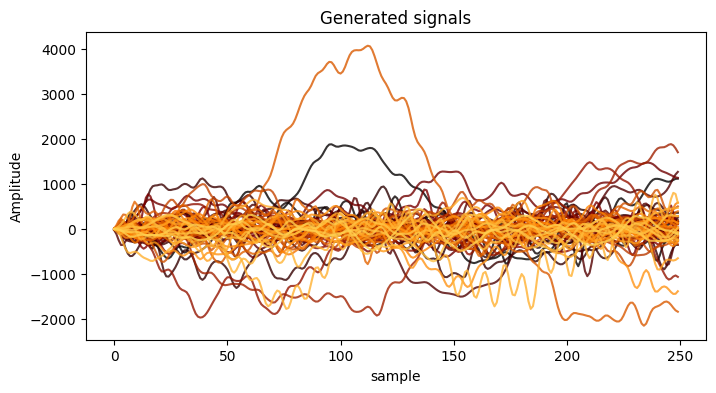

In [9]:
plt.figure(figsize=(8,4))
Fs=500
for i in range(len(cluster_arcoeff)):
    a,sigma=cluster_arcoeff[i]
    if lk_model['w_factor'] is not None:
        a=arcoeff_warp(a=a,warp_factor=lk_model['w_factor'],task="unwarp")
    #sigma=1
    # generate time series
    new_ts=gen_ts(a=a,sigma=np.sqrt(sigma),n_samples=int(Fs/2))

    plt.plot(new_ts, alpha=0.8,color=cmap(i / len(cluster_arcoeff)/1.5)) # 1.5 is for taking a subset of the colormap

plt.title('Generated signals')
plt.xlabel('sample')
plt.ylabel('Amplitude')
plt.show()

#### Feature dstribution for clusters

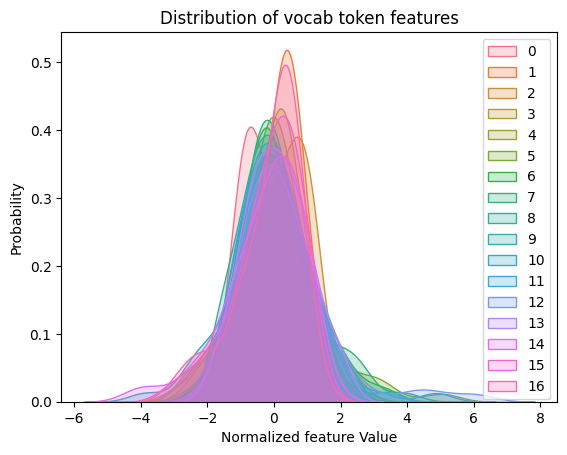

In [10]:
import seaborn as sns

cluster_features=lk_model['kmeans_model']['TokenMap'].values()
cluster_features=np.array(list(cluster_features))
total_feature=cluster_features.shape[1]

# Use a color palette from Seaborn for k KDE plots
colors = sns.color_palette('husl', n_colors=int(total_feature))

#plt.figure
# Create a figure and axis object
fig, ax = plt.subplots()
for i in range(total_feature):
    curr_f = cluster_features[:,i]
    #plt.hist(curr_f.T, bins=128,density=True, alpha=0.5)
    #sns.displot(curr_f.T,kind="kde",rug=True, fill=True,ax=ax) #https://seaborn.pydata.org/generated/seaborn.displot.html
    dlabel=str(i)
    dcolor=colors[i]
    sns.kdeplot(curr_f, fill=True,ax=ax,label=dlabel, color=dcolor) #https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot
    #plt.hist(curr_f.T, alpha=0.5)

plt.title('Distribution of vocab token features')
plt.xlabel('Normalized feature Value')
plt.ylabel('Probability')
#plt.yscale('log')  # Set y-axis to log scale
#plt.grid(axis='y')
plt.legend()
plt.show()